In [92]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.linear_model import LogisticRegression
from imblearn.pipeline import Pipeline
from wordcloud import STOPWORDS
import warnings
warnings.filterwarnings("ignore")

In [93]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,classification_report, confusion_matrix,recall_score,precision_score,f1_score

In [94]:
import nltk
from nltk.corpus import wordnet as wn
from nltk.stem.wordnet import WordNetLemmatizer

In [185]:
df = pd.read_csv(r"https://raw.githubusercontent.com/msaricaumbc/DS_data/master/ds602/dataset_newsletter.csv")

In [186]:
df.to_csv("newsletter.csv", index = False)

## Load Data

In [120]:
df = pd.read_csv("newsletter.csv")

In [121]:
df.head()

,Unnamed: 0,title,body,signature,submissiontime,category
0,0,Mrs. Laurence Class,"Because of the upcoming holiday, we will be re...",Jaslynn Laurence,11/18/15 9:26 AM,ANNOUNCEMENTS
1,1,Mr. Valle's Winter Break Packets (Cornell/Hamp...,"All my Cornell, Hampton, and Princeton student...",Mr. Sam Valle,12/16/15 9:26 PM,ANNOUNCEMENTS
2,2,Hours of Operation,"Parents/Guardians, We will gladly assist yo...",Ms. Ellis,11/18/15 3:30 PM,ANNOUNCEMENTS
3,3,Character Education,CMIT South scholars will continue to work on v...,Ch.Ed. Team Room 163,11/15/15 4:49 PM,ANNOUNCEMENTS
4,4,CMIT Students Connecting with Students Around ...,A couple of classes have had the opportunity t...,Srta. Dickerson,11/16/15 5:21 AM,ANNOUNCEMENTS


In [122]:
df = df.loc[:,~df.columns.str.contains("^Unnamed")]

In [123]:
df.head()

,title,body,signature,submissiontime,category
0,Mrs. Laurence Class,"Because of the upcoming holiday, we will be re...",Jaslynn Laurence,11/18/15 9:26 AM,ANNOUNCEMENTS
1,Mr. Valle's Winter Break Packets (Cornell/Hamp...,"All my Cornell, Hampton, and Princeton student...",Mr. Sam Valle,12/16/15 9:26 PM,ANNOUNCEMENTS
2,Hours of Operation,"Parents/Guardians, We will gladly assist yo...",Ms. Ellis,11/18/15 3:30 PM,ANNOUNCEMENTS
3,Character Education,CMIT South scholars will continue to work on v...,Ch.Ed. Team Room 163,11/15/15 4:49 PM,ANNOUNCEMENTS
4,CMIT Students Connecting with Students Around ...,A couple of classes have had the opportunity t...,Srta. Dickerson,11/16/15 5:21 AM,ANNOUNCEMENTS


In [124]:
print(df.shape)
df.info()


(19607, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19607 entries, 0 to 19606
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   title           19597 non-null  object
 1   body            19604 non-null  object
 2   signature       19207 non-null  object
 3   submissiontime  19607 non-null  object
 4   category        19607 non-null  object
dtypes: object(5)
memory usage: 766.0+ KB


In [125]:
df.describe()

,title,body,signature,submissiontime,category
count,19597,19604,19207,19607,19607
unique,12358,16358,2844,17778,12
top,2nd Grade News,.,Angie O'Brien,1/28/22 10:58 AM,ANNOUNCEMENTS
freq,147,130,777,7,10240


## Distribution of Target Variable

In [68]:
df['category'].value_counts()

ANNOUNCEMENTS        10240
BREAKING NEWS         3649
UPCOMING EVENTS       3055
PTO                   1507
IMPORTANT NEWS         452
CLUBS                  363
ATHLETICS              170
DONATIONS NEEDED        63
FIELD TRIPS             53
VOLUNTEERS NEEDED       27
ACHIEVEMENTS            25
STUDENT THOUGHTS         3
Name: category, dtype: int64

 #### It can be seen that the dataset is more imbalanced from the above distribution

<AxesSubplot: >

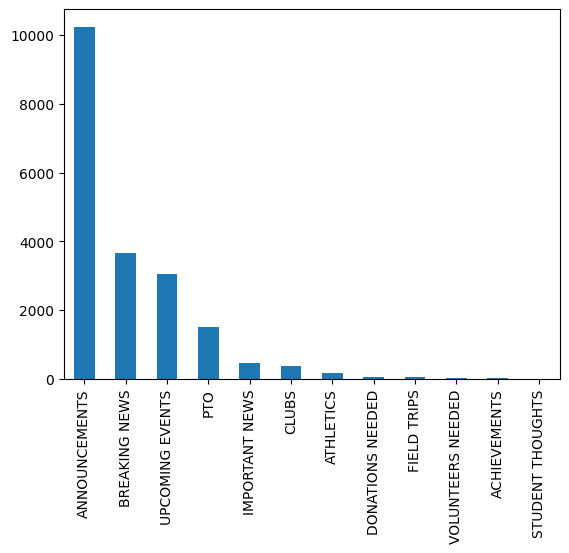

In [69]:
df['category'].value_counts().plot(kind='bar')

## EDA and Feature Engineering

In [70]:
df = df.drop(columns=['signature','submissiontime'])
df.head()

,title,body,category
0,Mrs. Laurence Class,"Because of the upcoming holiday, we will be re...",ANNOUNCEMENTS
1,Mr. Valle's Winter Break Packets (Cornell/Hamp...,"All my Cornell, Hampton, and Princeton student...",ANNOUNCEMENTS
2,Hours of Operation,"Parents/Guardians, We will gladly assist yo...",ANNOUNCEMENTS
3,Character Education,CMIT South scholars will continue to work on v...,ANNOUNCEMENTS
4,CMIT Students Connecting with Students Around ...,A couple of classes have had the opportunity t...,ANNOUNCEMENTS


#### Duplicate Removal

In [71]:
df.duplicated().sum()


2729

In [72]:
df.drop_duplicates(keep='last',inplace=True)

#### Merging two columns Title and Body

In [73]:
df1 = df.copy()
df1['news'] = df1['title'] + ' '+df1['body']

In [74]:
df1.drop(['title', 'body'], inplace=True, axis=1)


- Removed Duplicates from the data as it will bias the model
- Merged two features Title and body as part of feature engineering
- Dropped unnecessary features

## Data cleaning

In [75]:
df1['news'].fillna('',inplace=True)

In [76]:
df1.head()

,category,news
0,ANNOUNCEMENTS,Mrs. Laurence Class Because of the upcoming ho...
1,ANNOUNCEMENTS,Mr. Valle's Winter Break Packets (Cornell/Hamp...
2,ANNOUNCEMENTS,"Hours of Operation Parents/Guardians, We wi..."
3,ANNOUNCEMENTS,Character Education CMIT South scholars will c...
4,ANNOUNCEMENTS,CMIT Students Connecting with Students Around ...


In [77]:
df1['news'].head()

0    Mrs. Laurence Class Because of the upcoming ho...
1    Mr. Valle's Winter Break Packets (Cornell/Hamp...
2    Hours of Operation Parents/Guardians,    We wi...
3    Character Education CMIT South scholars will c...
4    CMIT Students Connecting with Students Around ...
Name: news, dtype: object

In [78]:
def convert_to_lower(text):
    return text.lower()
def remove_numbers(text):
    number_pattern = r'\d+'
    without_number = re.sub(pattern=number_pattern, repl=" ", string=text)
    return without_number

import string
def remove_punctuation(text):
    return text.translate(str.maketrans('', '', string.punctuation))

def remove_stopwords(text):
    removed = []
    stop_words = list(stopwords.words("english"))
    tokens = nltk.word_tokenize(text)
    for i in range(len(tokens)):
        if tokens[i] not in stop_words:
            removed.append(tokens[i])
    return " ".join(removed)
def remove_extra_white_spaces(text):
    single_char_pattern = r'\s+[a-zA-Z]\s+'
    without_sc = re.sub(pattern=single_char_pattern, repl=" ", string=text)
    return without_sc
def lemmatizing(text):
    lemmatizer = WordNetLemmatizer()
    tokens = nltk.word_tokenize(text)
    for i in range(len(tokens)):
        lemma_word = lemmatizer.lemmatize(tokens[i])
        tokens[i] = lemma_word
    return " ".join(tokens)

df1['news'] = df1['news'].apply(convert_to_lower)
df1['news'] = df1['news'].apply(remove_numbers)
df1['news'] = df1['news'].apply(remove_punctuation)
df1['news'] = df1['news'].apply(remove_stopwords)
df1['news'] = df1['news'].apply(remove_extra_white_spaces)
df1['news'] = df1['news'].apply(lemmatizing)


In [79]:
df1['news_processed'] = df1['news']

In [80]:
df1 = df1[~(df1['category'] == 'STUDENT THOUGHTS')]
### Removing this category as it has very less samples(3) which may not go in any of partitions of train or test split

### 
- Replaced the missing values with empty string
- Converted the text of news body to lower case
- Removed digits from the body
- Removed punctuations
- Removed stopwords
- Removed extra white spaces
- Lemmatized the text to convert all words to their root word

## Train Test Split

In [81]:
#train and test split
X = df1['news_processed']
#label encoding the target
label = LabelEncoder()
y = label.fit_transform(df1['category'])

In [82]:
#split the train and test dataset
X_train,X_test,y_train,y_test = train_test_split(X,y,stratify = y,test_size = 0.2,random_state=2)

In [83]:
print("The X_train shape----->",X_train.shape)
print('The X_text shape------>',X_test.shape)
print("THe y_train shape----->",y_train.shape)
print("The y_test shape------>",y_test.shape)

The X_train shape-----> (13500,)
The X_text shape------> (3375,)
THe y_train shape-----> (13500,)
The y_test shape------> (3375,)


In [84]:
# Creating copies of data for using it in pipeline
X_train1 = X_train.copy()
X_test1 = X_test.copy()
y_train1 = y_train.copy()
y_test1 = y_test.copy()

## Vectorization

Source - https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html

In [85]:
#tfidf vectorizer
vecto =  TfidfVectorizer(stop_words='english',max_df = 0.99,min_df=10,
                                   ngram_range=(1, 2),lowercase=True, max_features=5000)
vecto = vecto.fit(X_train)
X_train = vecto.transform(X_train).toarray()
X_test = vecto.transform(X_test).toarray()

 - Vectorization is performed here because the body of the news is the text feature
 - We have chosen TF-IDF vectorizer as it removes the most frequently occuring words(max_df ) and less frequent words (min_df) which is required to build accurate model and in order for it not to get biased towards those words 

In [87]:
from collections import Counter
counter = Counter(y_train)
print(counter)

Counter({1: 7015, 3: 2543, 9: 2096, 8: 984, 7: 350, 4: 267, 2: 128, 6: 41, 5: 38, 10: 21, 0: 17})


 - Utilized Counter for checking the distribution of class labels of data
 - Understood the majority and minority classes

### Undersampling and Over sampling

Source - https://machinelearningmastery.com/multi-class-imbalanced-classification/

In [88]:
from imblearn.under_sampling import RandomUnderSampler
undersample = RandomUnderSampler(sampling_strategy={1: 3000, 3: 2000, 9: 2000})
X_train, y_train = undersample.fit_resample(X_train, y_train)
strategy = { 8:2000, 7: 1000, 4: 1000, 2: 500, 6: 500, 5: 500, 10: 500, 0: 500}
oversample = SMOTE(sampling_strategy=strategy)
X_train, y_train = oversample.fit_resample(X_train, y_train)

- Here we have performed downsampling for the majority class labels and upsampled the data of minority class labels to make the dataset more balanced
- For upsampling, we have used SMOTE technique to generate synthetic samples which will be more meaningful rather than just duplicating the samples.  

In [89]:
from collections import Counter
counter = Counter(y_train)
print(counter)

Counter({1: 3000, 3: 2000, 8: 2000, 9: 2000, 4: 1000, 7: 1000, 0: 500, 2: 500, 5: 500, 6: 500, 10: 500})


## Model building

#### logistic Regresssion

In [95]:
#logistic Regresssion

log_reg = LogisticRegression()
log_reg.fit(X_train , y_train)

y_train_pred = log_reg.predict(X_train)
y_test_pred = log_reg.predict(X_test)

In [96]:
def classifier_scores(y_train,y_test, pred_train, pred_test):    
    print()
    print("Train data accuracy score: ", accuracy_score(y_train,pred_train))    
    print("Test data accuracy score: ", accuracy_score(y_test,pred_test))
    print()
    print("Recall score on train data: ", recall_score(y_train,pred_train, average='macro'))
    print("Recall score on test data: ",recall_score( y_test,pred_test, average='macro'))
    print()
    
    print("Precision score on train data: ",precision_score(y_train,pred_train, average='macro'))
    print("Precision score on test data: ",precision_score(y_test,pred_test, average='macro'))
    print()
    print("F1 score on train data: ",f1_score(y_train,pred_train, average='macro'))
    print("F1 score on test data: ",f1_score(y_test,pred_test, average='macro'))

In [97]:
classifier_scores(y_train,y_test,y_train_pred,y_test_pred)


Train data accuracy score:  0.8467407407407408
Test data accuracy score:  0.6322962962962962

Recall score on train data:  0.8963181818181819
Recall score on test data:  0.5409114217046116

Precision score on train data:  0.8948773013972393
Precision score on test data:  0.4671747185765302

F1 score on train data:  0.8949511645903317
F1 score on test data:  0.4892667073897231


#### Pipeline for the model with all the steps performed so far( vectorizer, sampling, Model)

In [105]:
log_reg = LogisticRegression()
pipeline = Pipeline([
    ('vecto', vecto),
    ('undersample', undersample),
    ('oversample', oversample),
    ('log_reg', log_reg)
])
pipeline.fit(X_train1 , y_train1)
y_train_pred1 = pipeline.predict(X_train1)
y_test_pred1 = pipeline.predict(X_test1)

In [106]:
classifier_scores(y_train1,y_test1,y_train_pred1,y_test_pred1)


Train data accuracy score:  0.7480740740740741
Test data accuracy score:  0.6391111111111111

Recall score on train data:  0.8620174564346357
Recall score on test data:  0.5413722876939735

Precision score on train data:  0.6549820230499772
Precision score on test data:  0.4529356412173228

F1 score on train data:  0.7370513590081077
F1 score on test data:  0.48598941344243285


- Since the data set is more imbalanced , accuracy wont be good metric or good measure for the fit of the model. 
- we have focused on just improving the F1 Score.  F1 score improved a lot by 15% only after making data balanced  by using sampling strategies

#### Logistic Regression  with hypertuning

In [107]:
param_grid = {'C': [0.1, 1, 10],
              'penalty': ['l1', 'l2'],
              'class_weight': [None, 'balanced']}

from sklearn.model_selection import GridSearchCV
lr = LogisticRegression()
gcv_results = GridSearchCV(lr, param_grid, cv=3)
gcv_results = gcv_results.fit(X_train, y_train)
score = gcv_results.score(X_test,y_test)
print(score)

0.621037037037037


In [108]:
y_test_pred_gcv = gcv_results.predict(X_test)

In [109]:
y_train_pred_gcv = gcv_results.predict(X_train)

In [110]:
classifier_scores(y_train,y_test,y_train_pred_gcv,y_test_pred_gcv)


Train data accuracy score:  0.9415555555555556
Test data accuracy score:  0.621037037037037

Recall score on train data:  0.9642424242424241
Recall score on test data:  0.5518231270335847

Precision score on train data:  0.9620990137832663
Precision score on test data:  0.5122421570390439

F1 score on train data:  0.9629824332856279
F1 score on test data:  0.5211538304780812


In [112]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_test_pred_gcv))

              precision    recall  f1-score   support

           0       0.33      0.25      0.29         4
           1       0.78      0.65      0.71      1754
           2       0.53      0.53      0.53        32
           3       0.50      0.57      0.54       636
           4       0.60      0.73      0.66        67
           5       0.57      0.44      0.50         9
           6       0.62      0.50      0.56        10
           7       0.24      0.28      0.26        88
           8       0.55      0.71      0.62       246
           9       0.49      0.60      0.54       524
          10       0.40      0.80      0.53         5

    accuracy                           0.62      3375
   macro avg       0.51      0.55      0.52      3375
weighted avg       0.65      0.62      0.63      3375



- Grid Search with hypertuning gave the best estimator with weighted average f1 score of 0.63 and macro average score of 0.52 after trying out all the combinations of paramters specified

#### Random Forest classifier

In [113]:
rand_f = RandomForestClassifier(random_state=0)
rf_pipeline = Pipeline([
    ('vecto', vecto),
    ('undersample', undersample),
    ('oversample', oversample),
    ('random_forest', rand_f)
])
rf_pipeline.fit(X_train1 , y_train1)
y_train_pred1 = rf_pipeline.predict(X_train1)
y_test_pred1 = rf_pipeline.predict(X_test1)

In [115]:
classifier_scores(y_train1,y_test1,y_train_pred1,y_test_pred1)


Train data accuracy score:  0.9045925925925926
Test data accuracy score:  0.6491851851851852

Recall score on train data:  0.9602485533241393
Recall score on test data:  0.46554146356736725

Precision score on train data:  0.9148331700431509
Precision score on test data:  0.6402655361190741

F1 score on train data:  0.9356148951189952
F1 score on test data:  0.51026181077617


## Conclusion

Logistic Regresssion with hypertuning approach performed the best of the three models we built with weighted average F1 score of 0.63. Sampling strategy helped improving the model by making more dataset balanced. Random Forest also performed good and gave similar results but it took bit more time to train the model and computationally expennsive compared to Logistic Regression. Hence we would consider the Logistic Regression hypertuned model as the final model for the News Classification.